# Multi-Layer Perceptron - Excess Return Forecasts

**Objectives**

* Train Feed-Forward Networks
  * Early Stopping
  * Activation Functions
  * Loss Functions
  * Optimizers
  * Shallow vs. Deep
* Forecast Excess Returns

## Data Import - Goyal Welch Excess Return Predictors

In [1]:
# !gdown --id 1OMWYlG7JXHN-PeBvQ1UBmfmlIuZP80fO

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1OMWYlG7JXHN-PeBvQ1UBmfmlIuZP80fO
To: /content/merged_data.csv
100% 981k/981k [00:00<00:00, 85.4MB/s]


## Library Imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Normalization
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import time

In [4]:
df_1 = pd.read_csv('merged_data.csv')

In [5]:
df_1.set_index('Date',inplace=True)

## Data Transformations

In [6]:
y = df_1['excess_returns']
X = df_1.drop('excess_returns',axis=1)

In [7]:
y.head()

Date
1959-03-01    0.001152
1959-04-01    0.038054
1959-05-01    0.021431
1959-06-01   -0.003225
1959-07-01    0.032004
Name: excess_returns, dtype: float64

In [8]:
X.head()

,CPIAUCSL,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DTCOLNVHFNM,DTCTHFNM,INVEST,D12,E12,b/m,lty,ntis,ltr,svar
Date,,,,,,,,,,,,,,,,,,,,,
1959-03-01,-0.000690,0.006430,0.007359,0.009410,-0.003423,0.008321,0.014303,0.006036,0.004899,0.000000,...,0.004929,0.004138,-0.014792,1.77000,3.11000,0.516860,0.0403,0.024984,0.0017,0.000492
1959-04-01,0.001380,0.006494,0.007049,-0.003639,0.019922,0.000616,0.021077,0.014338,0.014542,0.015653,...,0.012134,0.006734,0.024929,1.77667,3.20667,0.498597,0.0414,0.024361,-0.0117,0.000493
1959-05-01,0.001723,0.005763,0.006616,0.012005,0.006797,0.007803,0.014950,0.008269,0.009583,0.004768,...,0.002828,0.002020,-0.015342,1.78333,3.30333,0.483077,0.0417,0.025887,-0.0005,0.000428
1959-06-01,0.000339,0.003102,0.002974,0.003708,-0.000051,0.009064,0.001144,0.007034,0.007126,-0.004768,...,0.009726,0.009007,-0.012252,1.79000,3.40000,0.483219,0.0419,0.026882,0.0010,0.000915
1959-07-01,-0.001034,-0.000589,-0.000764,-0.003427,0.012110,-0.000330,-0.024238,0.001167,0.008247,0.013056,...,-0.004631,-0.001000,0.029341,1.79667,3.41000,0.460823,0.0417,0.027141,0.0060,0.000488


Generating the splits- We are going to use Min Max Scaler and use a very specific strategy in scaling our variables.

In [9]:
y

Date
1959-03-01    0.001152
1959-04-01    0.038054
1959-05-01    0.021431
1959-06-01   -0.003225
1959-07-01    0.032004
                ...   
2020-08-01    0.071968
2020-09-01   -0.038251
2020-10-01   -0.026509
2020-11-01    0.109303
2020-12-01    0.041473
Name: excess_returns, Length: 742, dtype: float64

In [10]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [11]:
X_train =scaler.fit_transform(X.loc[:'2018'])
X_valid = scaler.transform(X.loc['2019-01-01':'2019-12-01'])

In [12]:
X_test_0 = scaler.fit_transform(X.loc[:'2019'])
X_test = scaler.transform(X.loc['2020-01-01':'2020-12-01'])

In [13]:
y_train=y.loc[:'2018']
y_valid=y.loc['2019-01-01':'2019-12-01']
y_test=y.loc['2020-01-01':'2020-12-01']

In [14]:
X

,CPIAUCSL,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DTCOLNVHFNM,DTCTHFNM,INVEST,D12,E12,b/m,lty,ntis,ltr,svar
Date,,,,,,,,,,,,,,,,,,,,,
1959-03-01,-0.000690,0.006430,0.007359,0.009410,-0.003423,0.008321,0.014303,0.006036,0.004899,0.000000,...,0.004929,0.004138,-0.014792,1.770000,3.110000,0.516860,0.0403,0.024984,0.0017,0.000492
1959-04-01,0.001380,0.006494,0.007049,-0.003639,0.019922,0.000616,0.021077,0.014338,0.014542,0.015653,...,0.012134,0.006734,0.024929,1.776670,3.206670,0.498597,0.0414,0.024361,-0.0117,0.000493
1959-05-01,0.001723,0.005763,0.006616,0.012005,0.006797,0.007803,0.014950,0.008269,0.009583,0.004768,...,0.002828,0.002020,-0.015342,1.783330,3.303330,0.483077,0.0417,0.025887,-0.0005,0.000428
1959-06-01,0.000339,0.003102,0.002974,0.003708,-0.000051,0.009064,0.001144,0.007034,0.007126,-0.004768,...,0.009726,0.009007,-0.012252,1.790000,3.400000,0.483219,0.0419,0.026882,0.0010,0.000915
1959-07-01,-0.001034,-0.000589,-0.000764,-0.003427,0.012110,-0.000330,-0.024238,0.001167,0.008247,0.013056,...,-0.004631,-0.001000,0.029341,1.796670,3.410000,0.460823,0.0417,0.027141,0.0060,0.000488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,-0.001624,-0.032790,0.010429,0.006836,0.002130,0.008330,0.010522,0.013035,0.012572,0.007465,...,-0.005675,-0.002656,-0.016114,59.128628,98.556667,0.235975,0.0065,-0.008504,-0.0349,0.000743
2020-09-01,-0.001046,0.005666,0.009884,0.013125,0.006045,0.020661,-0.003034,-0.005733,-0.010124,-0.014893,...,-0.001469,0.002209,-0.001093,58.851237,98.220000,0.241482,0.0068,-0.005698,0.0080,0.004907
2020-10-01,-0.001253,-0.002717,0.013773,0.004091,0.009751,-0.000512,0.010856,0.010733,0.006639,0.002768,...,-0.008596,-0.005963,-0.000156,58.660440,96.856667,0.253146,0.0079,-0.001895,-0.0238,0.003661


# Building the Neural Network

## Some Universal Parameters

In [15]:
# Set the Patience Level of Early Stopping
# Iterations increase with patience

# Number of epochs with no improvement after which training will be stopped.


#patience = 2
#patience = 3
#patience = 4
#patience = 5
#patience = 6
#patience = 7
#patience = 8
#patience = 9
patience = 50

early_stop = EarlyStopping(monitor='val_loss',patience=patience)

In [16]:
### Select Activation Function by Uncommenting ###

#act_fn = 'elu'       # Exponential Linear Unit
#act_fn = 'gelu'      # Gaussian error linear unit
#act_fn = 'selu'      # Scaled Exponential Linear Unit 
act_fn = 'relu'      # Rectified Linear Unit
#act_fn = 'sigmoid'   # Sigmoid activation

In [17]:
### Select Loss Function by Uncommenting ###

#loss = 'mean_squared_error' # Mean Squared Error Loss
loss = 'huber' #Huber Loss
#loss = 'mean_absolute_error 

In [18]:
### Select Optimizer by Uncommenting ###

#optimizer = 'Adadelta' # Adadelta
optimizer = 'adam' # Adam
#optimizer = 'SGD'  # Stochastic Gradient Descent

## Neural Net with 1 Layer - Shallow Net - NN(1)

In [19]:
#neurons = 3
#neurons = 6
#neurons = 9
neurons = 119

In [20]:
epochs=500
normalizer = Normalization(axis=-1) 
model = Sequential(normalizer) # scale the input variables
model.add(Dense(neurons, activation=act_fn)) #define a single dense layer
model.add(Dense(1)) # output layer
model.compile(loss=loss, optimizer=optimizer) # Huber loss, mean square error
model.fit(X_train,y_train,validation_data = (X_valid,y_valid),epochs=epochs,callbacks=[early_stop]) #fit the model

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Epoch 1/500


2022-05-16 16:35:52.705647: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-16 16:35:52.705807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-16 16:35:52.869234: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-16 16:35:53.470696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 3s 22ms/step - loss: 0.0098 - val_loss: 0.0060
Epoch 2/500
13/23 [===============>..............] - ETA: 0s - loss: 0.0036

2022-05-16 16:35:55.512023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0079
Epoch 3/500
23/23 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0085
Epoch 4/500
23/23 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0060
Epoch 5/500
23/23 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0060
Epoch 6/500
23/23 [==============================] - 0s 5ms/step - loss: 9.8880e-04 - val_loss: 0.0059
Epoch 7/500
23/23 [==============================] - 0s 5ms/step - loss: 9.0745e-04 - val_loss: 0.0068
Epoch 8/500
23/23 [==============================] - 0s 5ms/step - loss: 7.4438e-04 - val_loss: 0.0043
Epoch 9/500
23/23 [==============================] - 0s 5ms/step - loss: 7.0390e-04 - val_loss: 0.0035
Epoch 10/500
23/23 [==============================] - 0s 5ms/step - loss: 6.1818e-04 - val_loss: 0.0032
Epoch 11/500
23/23 [==============================] - 0s 5ms/step - loss: 6.0163e-04 - val_loss: 0.0

In [21]:
model.evaluate(X_test,y_test) 

1/1 [==============================] - 0s 15ms/step - loss: 0.0373


0.037323422729969025

In [22]:
y_pred_nn1 = model.predict(X_test)

2022-05-16 16:36:26.492692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'Shallow NeuralNet Forecast')

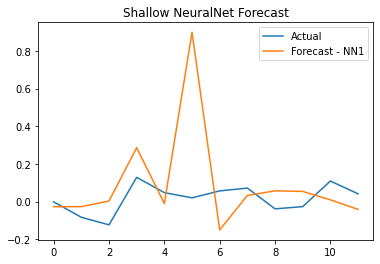

In [23]:
X_grid = np.arange(len(X_test))
X_grid = X_grid.reshape((len(X_grid), 1))
plt.plot(X_grid,y_test)
#plt.xlabel('date')
plt.plot(X_grid,y_pred_nn1)
plt.legend(('Actual','Forecast - NN1'))
plt.title('Shallow NeuralNet Forecast')
#plt.savefig('Shallow NeuralNet Test')

## Neural Net with 3 Layers

In [24]:
start_time = time.time()
epochs = 500
normalizer = Normalization(axis=-1)
model_dnn = Sequential(normalizer) # scale the input variables
model_dnn.add(Dense(119, activation=act_fn)) #define first dense layer with 119 neurons
model_dnn.add(Dense(50,  activation=act_fn)) #define first dense layer with 50 neurons
model_dnn.add(Dense(25,  activation=act_fn)) #define second dense layer with 25 neurons
model_dnn.add(Dense(1)) # output layer
model_dnn.compile(loss=loss, optimizer=optimizer) # define the loss and optimizer
model_dnn.fit(X_train,y_train,validation_data = (X_valid,y_valid),epochs=epochs,callbacks=[early_stop]) #fit the model
end_time = time.time()
end_time - start_time

Epoch 1/500
10/23 [============>.................] - ETA: 0s - loss: 0.0067

2022-05-16 16:36:33.101853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 13ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 2/500
23/23 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 3/500
 1/23 [>.............................] - ETA: 0s - loss: 8.7125e-04

2022-05-16 16:36:33.458299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 6ms/step - loss: 7.6251e-04 - val_loss: 0.0011
Epoch 4/500
23/23 [==============================] - 0s 6ms/step - loss: 6.3221e-04 - val_loss: 0.0010
Epoch 5/500
23/23 [==============================] - 0s 6ms/step - loss: 5.3771e-04 - val_loss: 0.0012
Epoch 6/500
23/23 [==============================] - 0s 6ms/step - loss: 5.1688e-04 - val_loss: 7.8079e-04
Epoch 7/500
23/23 [==============================] - 0s 6ms/step - loss: 4.4579e-04 - val_loss: 0.0011
Epoch 8/500
23/23 [==============================] - 0s 6ms/step - loss: 3.8267e-04 - val_loss: 8.8275e-04
Epoch 9/500
23/23 [==============================] - 0s 6ms/step - loss: 4.3662e-04 - val_loss: 8.6578e-04
Epoch 10/500
23/23 [==============================] - 0s 7ms/step - loss: 3.6347e-04 - val_loss: 8.5752e-04
Epoch 11/500
23/23 [==============================] - 0s 6ms/step - loss: 3.0446e-04 - val_loss: 9.9243e-04
Epoch 12/500
23/23 [==============================] - 0s 6ms/st

8.286339044570923

In [25]:
model_dnn.evaluate(X_test,y_test) 

1/1 [==============================] - 0s 15ms/step - loss: 0.0316


0.031626664102077484

In [26]:
y_pred_nn3 = model_dnn.predict(X_test)

2022-05-16 16:37:03.441490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'NeuralNet Test data')

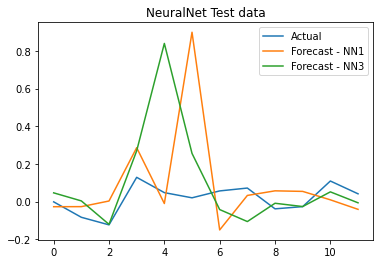

In [27]:
X_grid = np.arange(len(X_test))
X_grid = X_grid.reshape((len(X_grid), 1))
plt.plot(X_grid,y_test)
#plt.xlabel('date')
plt.plot(X_grid,y_pred_nn1)
plt.plot(X_grid,y_pred_nn3)
plt.legend(('Actual','Forecast - NN1','Forecast - NN3'))
plt.title('NeuralNet Test data')
#plt.savefig('NeuralNet Test')

In [28]:
epochs = 500
normalizer = Normalization(axis=-1)
model_dnn4 = Sequential(normalizer) # scale the input variables
model_dnn4.add(Dense(119, activation=act_fn)) 
model_dnn4.add(Dense(50, activation=act_fn))
model_dnn4.add(Dense(25, activation=act_fn))
model_dnn4.add(Dense(12, activation=act_fn))
model_dnn4.add(Dense(1)) # output layer
model_dnn4.compile(loss=loss, optimizer=optimizer) # define the loss and optimizer
model_dnn4.fit(X_train,y_train,validation_data = (X_valid,y_valid),epochs=epochs,callbacks=[early_stop]) #fit the model

Epoch 1/500


2022-05-16 16:37:20.511677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 8.4785e-04
Epoch 2/500
23/23 [==============================] - 0s 7ms/step - loss: 8.1080e-04 - val_loss: 7.0066e-04
Epoch 3/500


2022-05-16 16:37:21.308121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 7ms/step - loss: 7.6517e-04 - val_loss: 7.0222e-04
Epoch 4/500
23/23 [==============================] - 0s 7ms/step - loss: 7.7641e-04 - val_loss: 7.9515e-04
Epoch 5/500
23/23 [==============================] - 0s 7ms/step - loss: 6.9546e-04 - val_loss: 0.0012
Epoch 6/500
23/23 [==============================] - 0s 7ms/step - loss: 6.5321e-04 - val_loss: 0.0012
Epoch 7/500
23/23 [==============================] - 0s 7ms/step - loss: 5.8775e-04 - val_loss: 9.5357e-04
Epoch 8/500
23/23 [==============================] - 0s 6ms/step - loss: 5.4379e-04 - val_loss: 7.7560e-04
Epoch 9/500
23/23 [==============================] - 0s 7ms/step - loss: 5.1657e-04 - val_loss: 8.3208e-04
Epoch 10/500
23/23 [==============================] - 0s 7ms/step - loss: 4.6948e-04 - val_loss: 6.4034e-04
Epoch 11/500
23/23 [==============================] - 0s 6ms/step - loss: 4.4484e-04 - val_loss: 5.7034e-04
Epoch 12/500
23/23 [==============================] - 0

In [29]:
model_dnn4.evaluate(X_test,y_test) 

1/1 [==============================] - 0s 15ms/step - loss: 0.0219


0.021928129717707634

In [30]:
y_pred_nn4 = model_dnn4.predict(X_test)

2022-05-16 16:37:40.112627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'NeuralNet Test data')

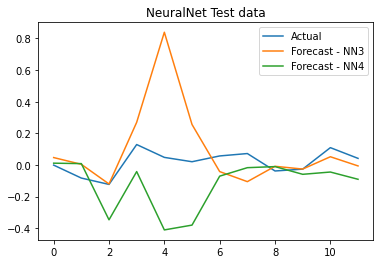

In [31]:
X_grid = np.arange(len(X_test))
X_grid = X_grid.reshape((len(X_grid), 1))
plt.plot(X_grid,y_test)
#plt.xlabel('date')
#plt.plot(X_grid,y_pred_nn1)
plt.plot(X_grid,y_pred_nn3)
plt.plot(X_grid,y_pred_nn4)
plt.legend(('Actual','Forecast - NN3', 'Forecast - NN4'))
plt.title('NeuralNet Test data')
#plt.savefig('NeuralNet Test')